# Progress Report

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Environment

The project is expected to run in a virtual environment in python 3.10.8. Please install the necessary packages from `requirements.txt`. Only Windows and MacOS (MPS) are supported at this time.

## Data Collection

In our project proposal we decided to use the [WikiART General Dataset](https://github.com/asahi417/wikiart-image-dataset?tab=readme-ov-file#wikiart-general). However, the dataset had issues with metadata file and with missing/duplicate images. Additionally, it didn't have all the classes we wanted for a good representation of notable art styles. We decided to make our own dataset called [wikiART224](https://drive.google.com/file/d/1sCCx07IUIdjS5aSDCpTQyV9SWzY-AjXN/view?usp=drive_link) and [wikiART9](https://drive.google.com/file/d/1xAETK5FzFYe7vsyITIFTRhtTWco_AnVF/view?usp=sharing), which we cited as an alternative in our proposal [(WikiArt Dataset)](https://archive.org/details/wikiart-dataset).

wikiART224 is created by adding zero-padding to the smallest dimension of the image until we reach 1:1 aspect ratio. The image is then resized to 224x224 for ResNET.
wikiART9 is created by adding zero-padding to the smallest dimension of the image until we reach 1:1 aspect ratio. The image is then segmented into a 3x3 grid and then each subimage is resized to 224x224 for ResNET. The resulting metadata can be found in [`labels.csv`](https://docs.google.com/spreadsheets/d/18SrwCjfP3gplKnSfoyhFhL3PrOB6y_zlf6TWNyFgIiQ/edit?usp=drive_link). The target classes are *art style* and *genre*.

The datasets were created using the following python files: `data_clean.ipynb` and `data_process.ipynb`. The first file was used to clean/correct the dataset's metadata by adding in artist, style, and genre information which was partially missing from the source dataset's metadata as only some labels were in the `classes.php` file. The second file was used to transform the source data into our datasets. Both the datasets and metadata is hosted on our project's Google Drive. The python files are hosted on the project github, it is not suggested to run them as it will take a long time due to the size of the datasets (32 GB).

### Summary of Data

*Please note that wikiART9 has 9x the images of wikiART224 but the exact same distributions as they are subimages. The data will not be plotted twice for brevity.*

In [3]:
import pandas as pd
file_path = 'Dataset\\labels.csv'
df = pd.read_csv(file_path)

In [9]:
print(f"Number of samples - wikiART224: {df.shape[0]}")
print(f"Number of samples - wikiART9: {9*df.shape[0]}")

Number of samples - wikiART224: 81444
Number of samples - wikiART9: 732996


We have 81444 and 732996 samples for wikiART224 and wikiART9, respectively.

In [5]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)

In [6]:
# Show distribtion (barplot) art style
fig_art_style = px.bar(df['art_style'].value_counts(), x=df['art_style'].value_counts().index, y=df['art_style'].value_counts().values, labels={'y': 'Count', 'x': 'Art Style'},
                       title='Distribution of Data by Art Style')
fig_art_style.update_layout(width=1000, height=500)
fig_art_style.show()

In [7]:
# Calculate the proportion of NaN values in the genre
nan_proportion_genre = df['genre'].isna().sum() / len(df)
# Create a pie chart for the proportion of NaN values in genre
fig_nan_genre = px.pie(names=['Missing Values', 'Present Values'],
                      values=[nan_proportion_genre, 1 - nan_proportion_genre],
                      title='Proportion of Missing Values in Genre Column')
fig_nan_genre.update_layout(width=600, height=400)
fig_nan_genre.show()

The data on wikiART does not have labels for genre for all images. Around 20% are unlabelled or belong to an other class with low representation. 

In [8]:
# Show distribtion (barplot) genre
fig_genre = px.bar(df['genre'].value_counts(), x=df['genre'].value_counts().index, y=df['genre'].value_counts().values, labels={'y': 'Count', 'x': 'Genre'},
                   title='Distribution of Data by Genre')
fig_genre.update_layout(width=800, height=500)
fig_genre.show()

## Results Achieved

### Style Classification Model: Resnet18

Please note that not all the codes are given below. Only the essential codes are shown for visibility. 

In [ ]:
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.models import resnet18
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

import os
import zipfile
from PIL import Image
import dill as pickle


from tqdm import tqdm
from time import time

#### 1) load data

In [ ]:
rawdata_dir = os.path.join(unzipped_dir, 'wikiART224')
train_loader, val_loader, test_loader = custom_dataloader(rawdata_dir)

data loading completed


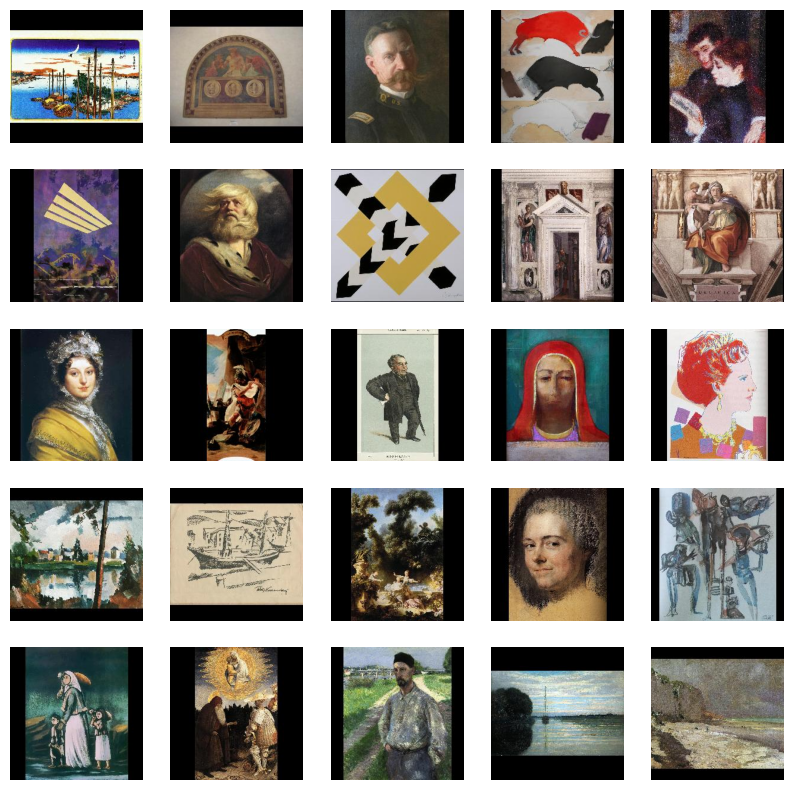

In [ ]:
data_iter = iter(train_loader)

images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,10), ncols=5, nrows=5)
for i in range(5):
  for ii in range(5):
    ax = axes[i,ii]
    ax.imshow(images[i * 5 + ii].permute(1, 2, 0))
    ax.axis('off')

#### 2) model building

In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 27),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [ ]:
def train_model(dl_train, dl_val, idx_fold, epoch=1):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []
    accuracy_train_track, avg_acc_val = [], []
    epoch_track, iteration_track = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    num_classes = len(dl_train.dataset.classes)  # Number of classes

    epochs = epoch
    iter = 1
    start_time = time.time()
    for idx in range(1, epochs+1):
        loss_train_epoch, loss_val_epoch = [], []
        accuracy_val_epoch = []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            loss_train_epoch, Y_hat_train_epoch, Y_train_epoch, accuracy_train_track, epoch_track, iteration_track, iter = \
                training_batch(X, Y, loss_train_epoch, Y_hat_train_epoch, Y_train_epoch, accuracy_train_track, epoch_track, iteration_track, iter)

        for X, Y in tqdm(dl_val, leave=False):
            loss_val_epoch, Y_hat_val_epoch, Y_val_epoch, accuracy_val_epoch = \
                val_batch(X, Y, loss_val_epoch, Y_hat_val_epoch, Y_val_epoch, accuracy_val_epoch)

        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)
        avg_acc_val.append(np.mean(accuracy_val_epoch))

        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}, " \
            f"train accuracy: {accuracy_train_track[-1]}, "\
            f"val accuracy: {avg_acc_val[-1]}, "
            f"elapsed time: {elapsed_time}"
        )

        lr_scheduler.step()

        train_results = {
            "loss_train": loss_train,
            "loss_val": loss_val,
            "accuracy_train": accuracy_train_track,
            "accuracy_val":avg_acc_val,
            "epoch_track": epoch_track,
            "iteration_track": iteration_track
        }

        torch.save(model, f"resnet18_fold{idx_fold}_{idx}.pth")
        pickle.dump(train_results, open(f"train_results_fold{idx_fold}_{idx}.pkl", "wb"))


#### 3) Training Results

In [ ]:
train_model(train_loader, val_loader, 'epoch4', epoch=4)

In [ ]:
model4 = torch.load("resnet18_foldepoch4_4.pth")
train_results = pickle.load(open("train_results_foldepoch4_4.pkl", "rb"))

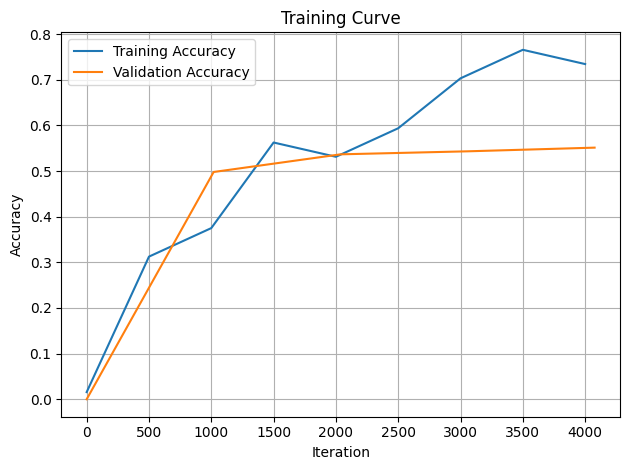

In [ ]:
plt.plot(range(0, len(accuracy_train), 500), accuracy_train[::500], label='Training Accuracy')

# Overlay accuracy_val data
epochs_val = [1019 * i for i in range(0, len(accuracy_val) )]  # Epochs for accuracy_val
plt.plot(epochs_val, accuracy_val, label='Validation Accuracy')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4) Testing
Testing accuracy is 55%. The confusion matrix is shown below. 

In [ ]:
loss, accuracy, Y_hat, Y_test = test_model(test_loader, model4)

  0%|          | 0/128 [00:00<?, ?it/s]

test lostt: 0.08313283888855949, test accuracy: 0.5510756548713236


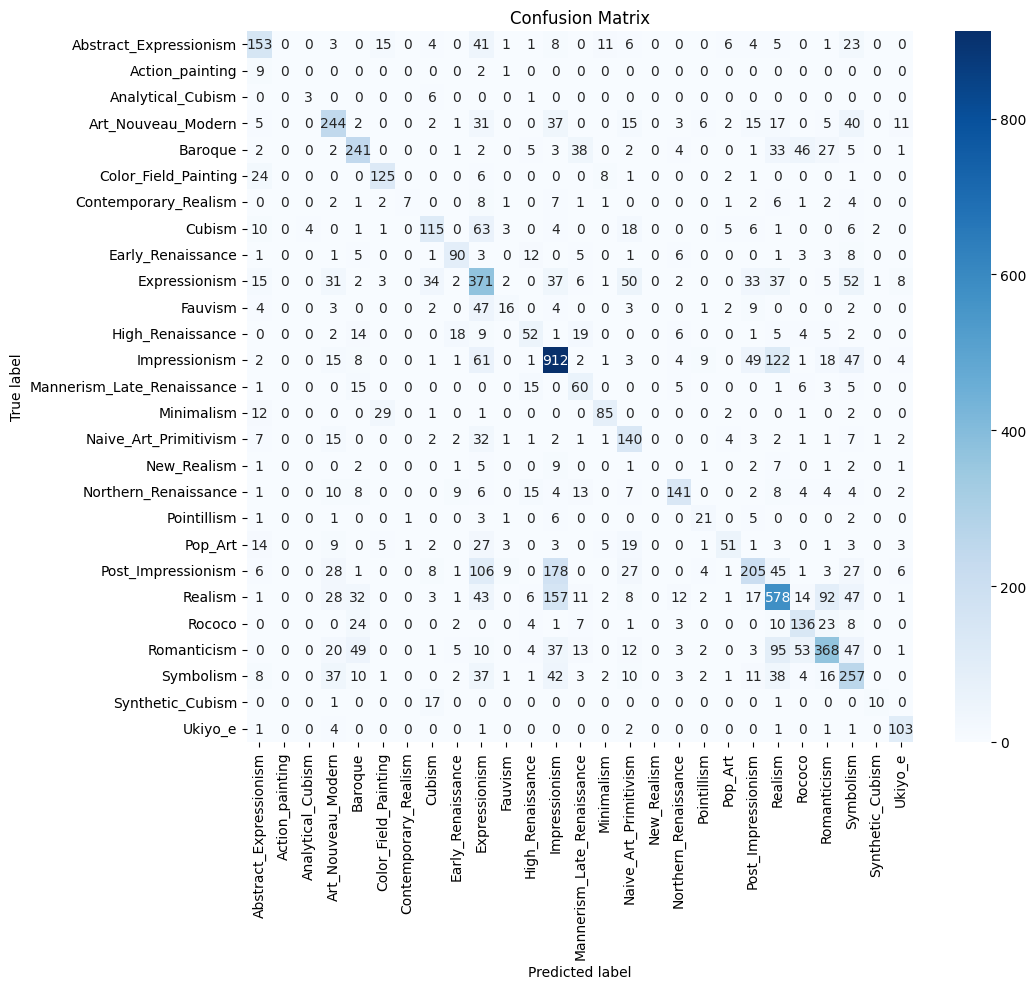

In [ ]:
rawdata_dir = os.path.join(unzipped_dir, 'wikiART224')
raw_dataset = datasets.ImageFolder(root=rawdata_dir)
C = plot_confusion(Y_hat, Y_test, raw_dataset)

#### 5) Demonstration of testing an image

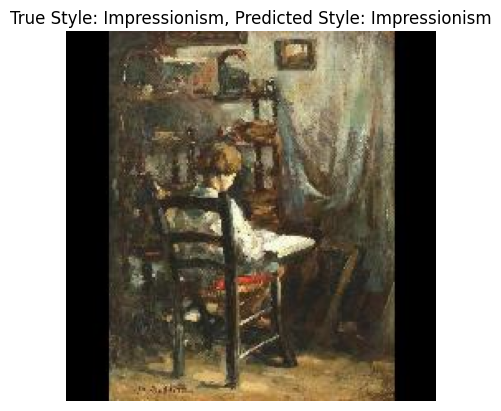

In [ ]:
image = test_image('adam-baltatu_the-lesson.jpg', model4)

#### Genre Classification Model: Resnet18

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
%run customize_dataloader.py
dataset_dir = 'C:/Users/ASUS/Documents/UofT MEng/Winter 2023-2024/MIE1517 Introduction to Deep Learning/Course project/Data/wikiART224_genre'
train_loader, val_loader, test_loader = get_data_loaders(dataset_dir, batch_size=32)

In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
resnet.name = 'ResNet18_second_training'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 55),
    nn.ReLU(),
    nn.Linear(55, 11))

state = torch.load('model_ResNet18_second_training_bs64_lr0.001_epoch18', map_location=torch.device('cpu'))
resnet.load_state_dict(state)

C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
#Create lists to store labels and predictions
all_labels = []
all_predictions = []

# Iterate over the test loader
for imgs, labels in test_loader:

    # Forward pass
    output = resnet(imgs)

    # Select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]

    # Convert tensors to numpy arrays and append to lists
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(pred.cpu().numpy())

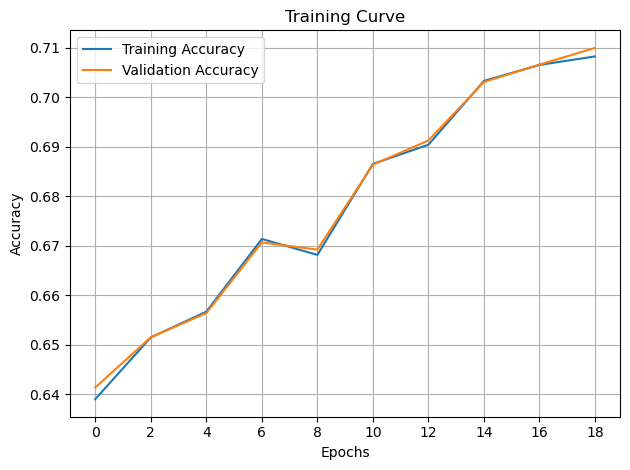

In [ ]:
# Import training results
epochs_2 = pd.read_csv('epochs_2.csv')
train_acc_2 = pd.read_csv("train_acc_2.csv")
val_acc_2 = pd.read_csv("val_acc_2.csv")

# Plot Learning Curve
plt.plot(epochs_2, train_acc_2, label='Training Accuracy')
plt.plot(epochs_2, val_acc_2, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.xticks(epochs_2['epochs'].to_list())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Test accuracy
print(f'Test accuracy: {get_accuracy(resnet, test_loader)}')

Test accuracy: 0.6827850605985655


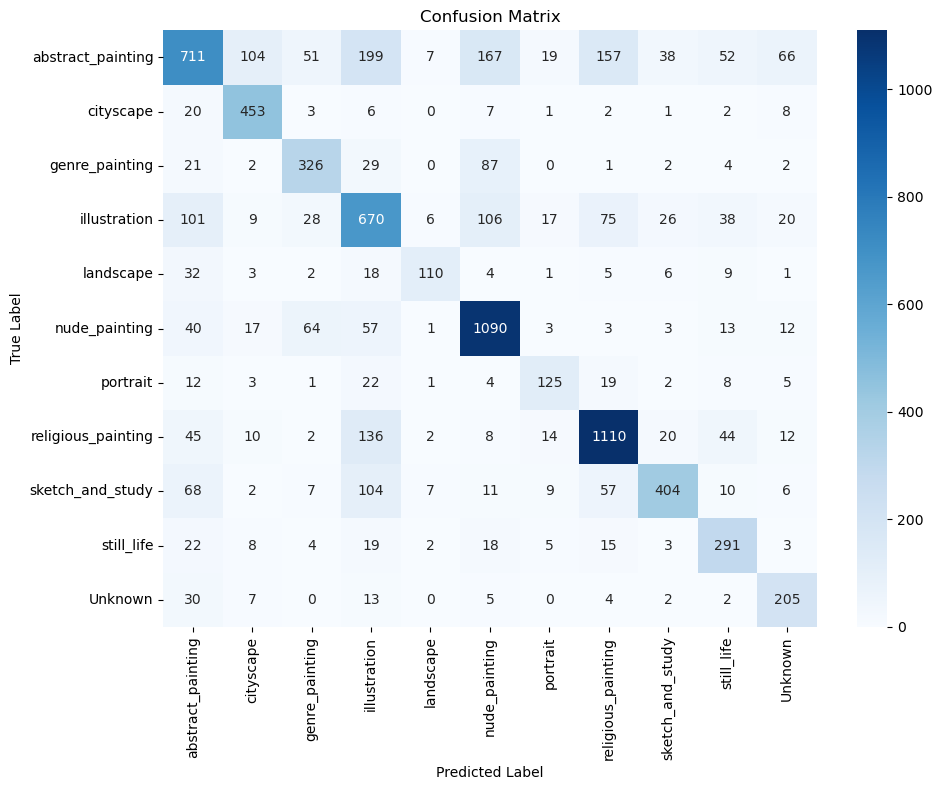

In [ ]:
# Plot Confusion Matrix
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
classes = os.listdir(dataset_dir)
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

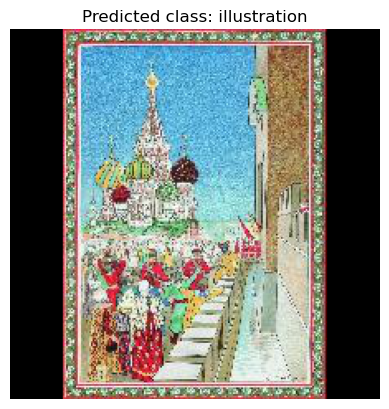

In [ ]:
# Load the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

image_path = dataset_dir+"/illustration/andrei-ryabushkin_illustration-for-the-coronation-album.jpg"
image = Image.open(image_path)
image_tensor = transform(image)
image = image_tensor.unsqueeze(0)  # Add batch dimension

# Make prediction
output = resnet(image)

# Get predicted class
pred = output.max(1, keepdim=True)[1]
classes = os.listdir(dataset_dir)

# Show the image
plt.imshow(image_tensor.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Predicted class: {classes[pred]}')
plt.show()

#### Image Captioning Model: BLIP by Salesforce

In [2]:
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration

import os
import random

c:\Anaconda\envs\curationsystem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

In [4]:
image_folder = './wikiART224'

In [5]:
def process_images_by_style_randomly(model, processor, directory, style, print_limit=10, text_prompt = "a art piece of"):
    style_path = os.path.join(directory, style)  # Construct the path to the specific style

    if not os.path.exists(style_path):
        print(f"The specified style '{style}' does not exist in the given directory.")
        return
    
    image_files = []
    for root, dirs, files in os.walk(style_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_path = os.path.join(root, file)
                image_files.append((image_path, root))
    
    # Shuffle the list of image files to process them in random order
    random.shuffle(image_files)
    
    for image_path, root in image_files[:print_limit]:  # Process only up to the print limit
        raw_image = Image.open(image_path).convert('RGB')
                
        # Display the image
        plt.figure(figsize=(10, 5))
        plt.imshow(raw_image)
        plt.axis('off')  # Hide the axis
                
        # Process the image and text prompt
        inputs = processor(raw_image, text_prompt, return_tensors="pt").to("cuda")
                
        # Generate the caption
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
                
        # Extract artist from the path (assuming art style is already known)
        artist = root.split(os.sep)[-1]
                
        # Print the caption below the image
        plt.title(f"Art Style: {style},\nFile: {file}\nCaption: {caption}", fontsize=10)
        plt.show()

c:\Anaconda\envs\curationsystem\lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


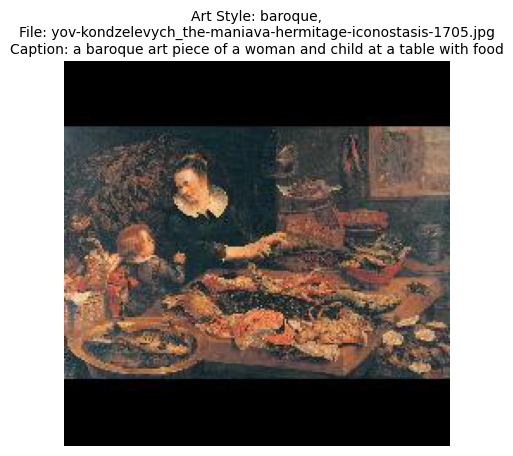

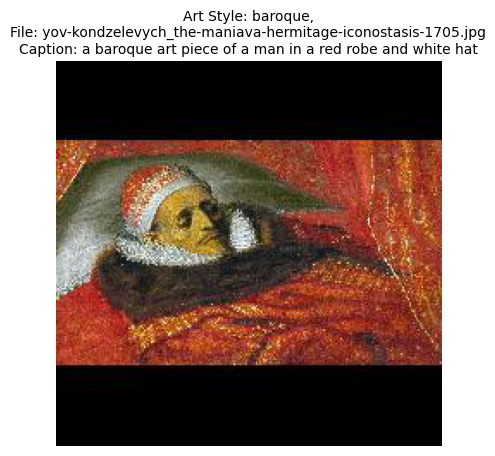

In [6]:
process_images_by_style_randomly(model,processor,image_folder, 'baroque', print_limit=2, text_prompt ="a baroque art piece of")

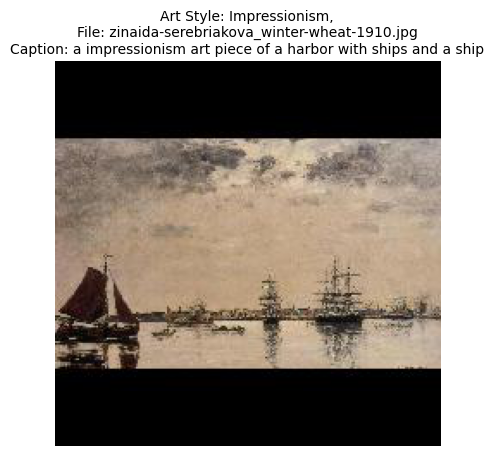

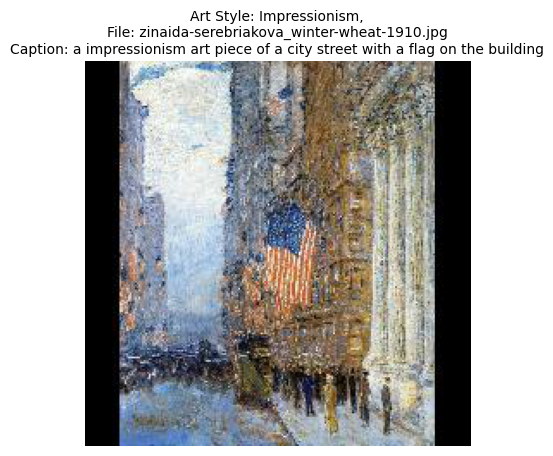

In [7]:
process_images_by_style_randomly(model,processor,image_folder, 'Impressionism', print_limit=2, text_prompt ="a impressionism art piece of")

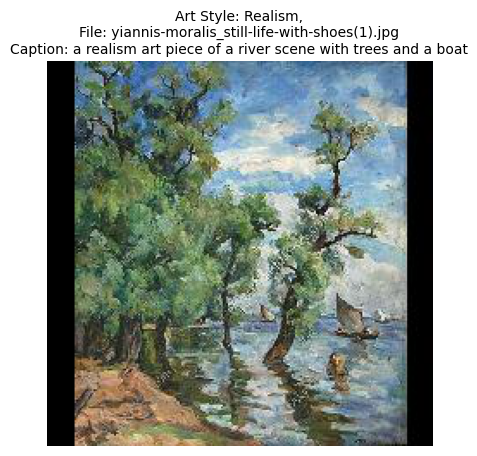

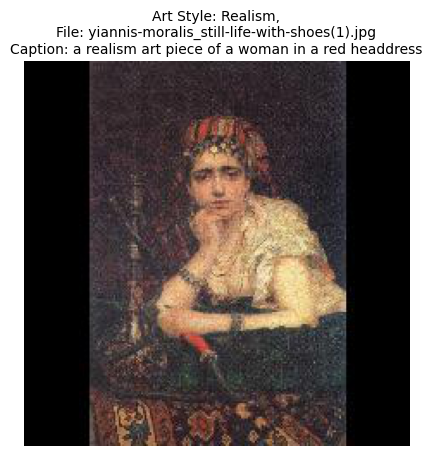

In [8]:
process_images_by_style_randomly(model,processor,image_folder, 'Realism', print_limit=2, text_prompt ="a Realism art piece of")

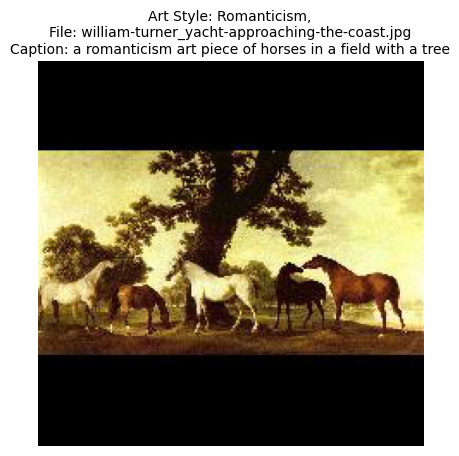

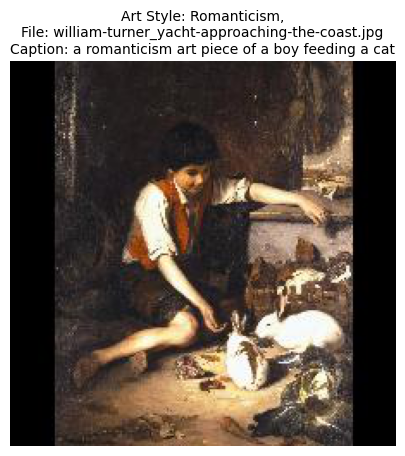

In [9]:
process_images_by_style_randomly(model,processor,image_folder, 'Romanticism', print_limit=2, text_prompt ="a Romanticism art piece of")

### Remark
Data collection and baseline model of Style CNN, Genre CNN and Image captioning model have been created. 
Although the models still need fine tuning for better results, they outputs promising results for the classification and captioning tasks. 
For the final results, these three models with futher fine tuning will be integrated with prompt engineering to give art curation.